<a href="https://colab.research.google.com/github/faisalahm3d/Brain-Tumor-Classification-Using-Transfer-Learning/blob/main/Two_Channel_CNN_Structural_Evolutionary_with_Squenze_and_Excitation_Tyrosine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def calculate_performance(test_num, pred_y, labels):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for index in range(test_num):
        if labels[index] == 1:
            if labels[index] == pred_y[index]:
                tp = tp + 1
            else:
                fn = fn + 1
        else:
            if labels[index] == pred_y[index]:
                tn = tn + 1
            else:
                fp = fp + 1

    # entering any of the else statement means that the evaluation metric is invalid
    acc = float(tp + tn) / test_num
    
    if((tp + fp) != 0):
      sensitivity = float(tp) / (tp + fn)
    else:
      sensitivity = 0

    if((tn + fp) != 0):
      specificity = float(tn) / (tn + fp)
    else:
      specificity = 0
    
    precision = tp / (tp + fp)

    MCC = float(tp * tn - fp * fn) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    
    return acc, sensitivity, specificity, precision, MCC

In [ ]:
import numpy as np
npzfile = np.load('/content/drive/MyDrive/DLPhos/normalized_balanced_pssm_spd_profile/train_balanced_Y_10.npz', allow_pickle=True)
x_train= npzfile['arr_0']
y_train= npzfile['arr_1']
x_test = npzfile['arr_2']
y_test = npzfile['arr_3']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=10)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:
y_test

array([0, 0, 0, ..., 1, 1, 0], dtype=int32)

In [ ]:
from tensorflow.keras.utils import to_categorical as labelEncoding
y_train = labelEncoding(y_train, dtype=int)
y_test  = labelEncoding(y_test, dtype=int)

In [ ]:
def get_pssm_spd(data):
  row, col = data.shape
  print (row)
  pssm= data[:, :420]
  spd = data[:, 420:]
  return np.array([pssm[r,:].reshape(21,20) for r in range(row)]), np.array([spd[r, :].reshape(21,8) for r in range(row)])

In [ ]:
x_test.shape

(7306, 588)

In [ ]:
x_train.shape

(55182, 588)

In [ ]:
trainX1, trainX2 = get_pssm_spd(x_train)
testX1, testX2 = get_pssm_spd(x_test)
valX1, valtX2 = get_pssm_spd(x_val)

22797
3496
2533


In [ ]:
trainX1.shape

(46904, 21, 20)

In [ ]:
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, MaxPooling1D, Flatten,concatenate,GlobalMaxPool1D
from keras import Model
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from keras import regularizers
from keras.regularizers import (l1, l2, l1_l2)
from keras.callbacks import (EarlyStopping, ModelCheckpoint)
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
from keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                                     Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,GlobalAveragePooling1D,
                                     LSTM, GRU, Embedding, Bidirectional, Concatenate, Multiply)

In [ ]:
def get_structural_model():
    ### Head-1:
    input1 = Input(shape=trainX2[0].shape)

    x = Conv1D(filters=64, kernel_size=5, padding='same', kernel_regularizer=l2(l=0.01))(input1)
    #x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    #x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    #x = BatchNormalization()(x)
    #x = Dropout(rate=0.50)(x)
    shortcut = x
	  # calculate the number of filters the input has
    filters = x.shape[-1]
	  # the squeeze operation reduces the input dimensionality
	  # here we do a global average pooling across the filters, which
	  # reduces the input to a 1D vector
    x = GlobalAveragePooling1D()(x)
	  # reduce the number of filters (1 x 1 x C/r)
    x = Dense(filters // 16, activation="relu", kernel_initializer="he_normal", use_bias=False)(x)
	
	  # the excitation operation restores the input dimensionality
    x = Dense(filters, activation="sigmoid",kernel_initializer="he_normal", use_bias=False)(x)
	
	  # multiply the attention weights with the original input
    x = Multiply()([shortcut, x])

    head1 = Flatten()(x)

    z= Dense(units=256, activation='relu',)(head1)
    z = Dropout(rate=0.5)(z)

    z = Dense(units=64, activation='relu',)(z)
    z = Dropout(rate=0.5)(z)

    z = Dense(units=16, activation='relu',)(z)
    z = Dropout(rate=0.5)(z)
    
    z = Dense(1, activation='sigmoid')(z)

    return Model(inputs=[input1], outputs=[z])
#end-def

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21, 8)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 21, 64)       2624        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 21, 64)       0           ['conv1d[0][0]']                 
                                                                                                  
 global_average_pooling1d (Glob  (None, 64)          0           ['dropout[0][0]']                
 alAveragePooling1D)                                                                          

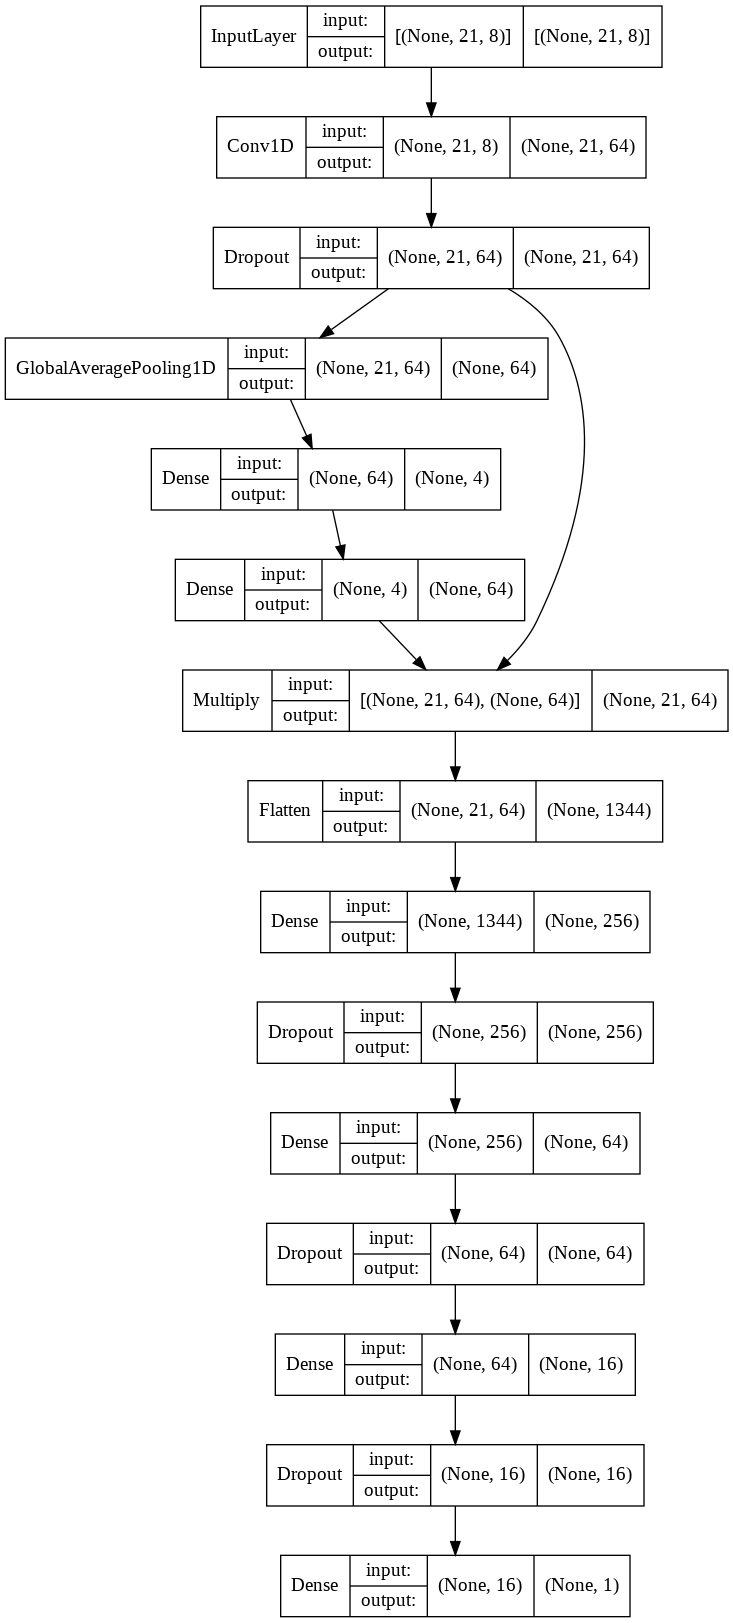

In [ ]:
model = get_structural_model()
model.summary()
plot_model(model, to_file='model-spd.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [ ]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# save the best model
mc = ModelCheckpoint('best_model_spd.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
# Compile Model:
#model = Ne()
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Run Model:
history = model.fit(x=trainX2, y= y_train, validation_data=(valtX2, y_val), batch_size=32, epochs=200, verbose=1, callbacks=[es,mc])

Epoch 1/200
713/713 [==============================] - ETA: 0s - loss: 0.7434 - accuracy: 0.6235
Epoch 1: val_accuracy improved from -inf to 0.68259, saving model to best_model_spd.h5
713/713 [==============================] - 16s 5ms/step - loss: 0.7434 - accuracy: 0.6235 - val_loss: 0.6573 - val_accuracy: 0.6826
Epoch 2/200
707/713 [============================>.] - ETA: 0s - loss: 0.6472 - accuracy: 0.6850
Epoch 2: val_accuracy improved from 0.68259 to 0.69562, saving model to best_model_spd.h5
713/713 [==============================] - 3s 4ms/step - loss: 0.6474 - accuracy: 0.6851 - val_loss: 0.6198 - val_accuracy: 0.6956
Epoch 3/200
711/713 [============================>.] - ETA: 0s - loss: 0.6053 - accuracy: 0.7092
Epoch 3: val_accuracy improved from 0.69562 to 0.71733, saving model to best_model_spd.h5
713/713 [==============================] - 3s 5ms/step - loss: 0.6053 - accuracy: 0.7093 - val_loss: 0.5829 - val_accuracy: 0.7173
Epoch 4/200
710/713 [===========================

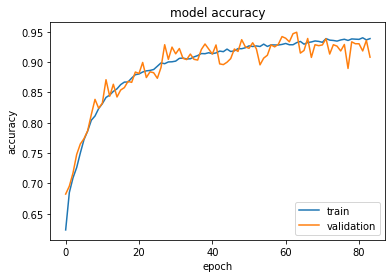

In [ ]:
from matplotlib import pyplot as plt
#plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='lower right')
plt.savefig('accuracy_curve_spd_balanced_smote.png')
plt.show()

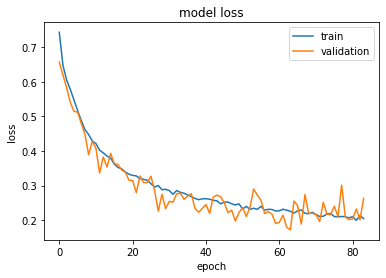

In [ ]:
#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.savefig('loss_curve_spd_balanced_smote.png')
plt.show()

In [ ]:
# load the saved model
saved_model = load_model('best_model_spd.h5')
# evaluate the model
#_, train_acc = saved_model.evaluate(trainX, trainy, verbose=0)
#_, test_acc = saved_model.evaluate(testX, testy, verbose=0)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

In [ ]:
probabilities = saved_model.predict(valtX2)
predicted_classes = probabilities >= 0.5
predicted_classes = predicted_classes.astype(int)
acc, sensitivity, specificity, precision, MCC = calculate_performance(len(y_val),predicted_classes , y_val)

print('Result Summary:')
print('------------------------------')
print('accuracy: ',acc, end =", ")
print('sensitivity: ',sensitivity, end =", ")
print('specificity: ',specificity, end =" ,")
print('precision: ',precision, end =" ,")
print('MCC : ',MCC)

Result Summary:
------------------------------
accuracy:  0.9490722463482038, sensitivity:  0.9895245769540693, specificity:  0.9102167182662538 ,precision:  0.9136904761904762 ,MCC :  0.9012478455959889


In [ ]:
def get_evolutionary_model():
    ### Head-1:
    input1 = Input(shape=trainX1[0].shape)

    x = Conv1D(filters=64, kernel_size=5, padding='same', kernel_regularizer=l2(l=0.01))(input1)
    #x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    #x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    #x = BatchNormalization()(x)
    #x = Dropout(rate=0.50)(x)
    shortcut2 = x
	  # calculate the number of filters the input has
    filters2 = x.shape[-1]
	  # the squeeze operation reduces the input dimensionality
	  # here we do a global average pooling across the filters, which
	  # reduces the input to a 1D vector
    x = GlobalAveragePooling1D(keepdims=True)(x)
	  # reduce the number of filters (1 x 1 x C/r)
    x = Dense(filters2 // 16, activation="relu", kernel_initializer="he_normal", use_bias=False)(x)
	
	  # the excitation operation restores the input dimensionality
    x = Dense(filters2, activation="sigmoid",kernel_initializer="he_normal", use_bias=False)(x)
	
	  # multiply the attention weights with the original input
    x = Multiply()([shortcut2, x])


    head1 = Flatten()(x)

    z= Dense(units=256, activation='relu',)(head1)
    z = Dropout(rate=0.5)(z)

    z = Dense(units=64, activation='relu',)(z)
    z = Dropout(rate=0.5)(z)

    z = Dense(units=16, activation='relu',)(z)
    z = Dropout(rate=0.5)(z)
    
    z = Dense(1, activation='sigmoid')(z)

    return Model(inputs=[input1], outputs=[z])
#end-def

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 21, 20)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 21, 64)       6464        ['input_2[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 21, 64)       0           ['conv1d_1[0][0]']               
                                                                                                  
 global_average_pooling1d_1 (Gl  (None, 1, 64)       0           ['dropout_4[0][0]']              
 obalAveragePooling1D)                                                                      

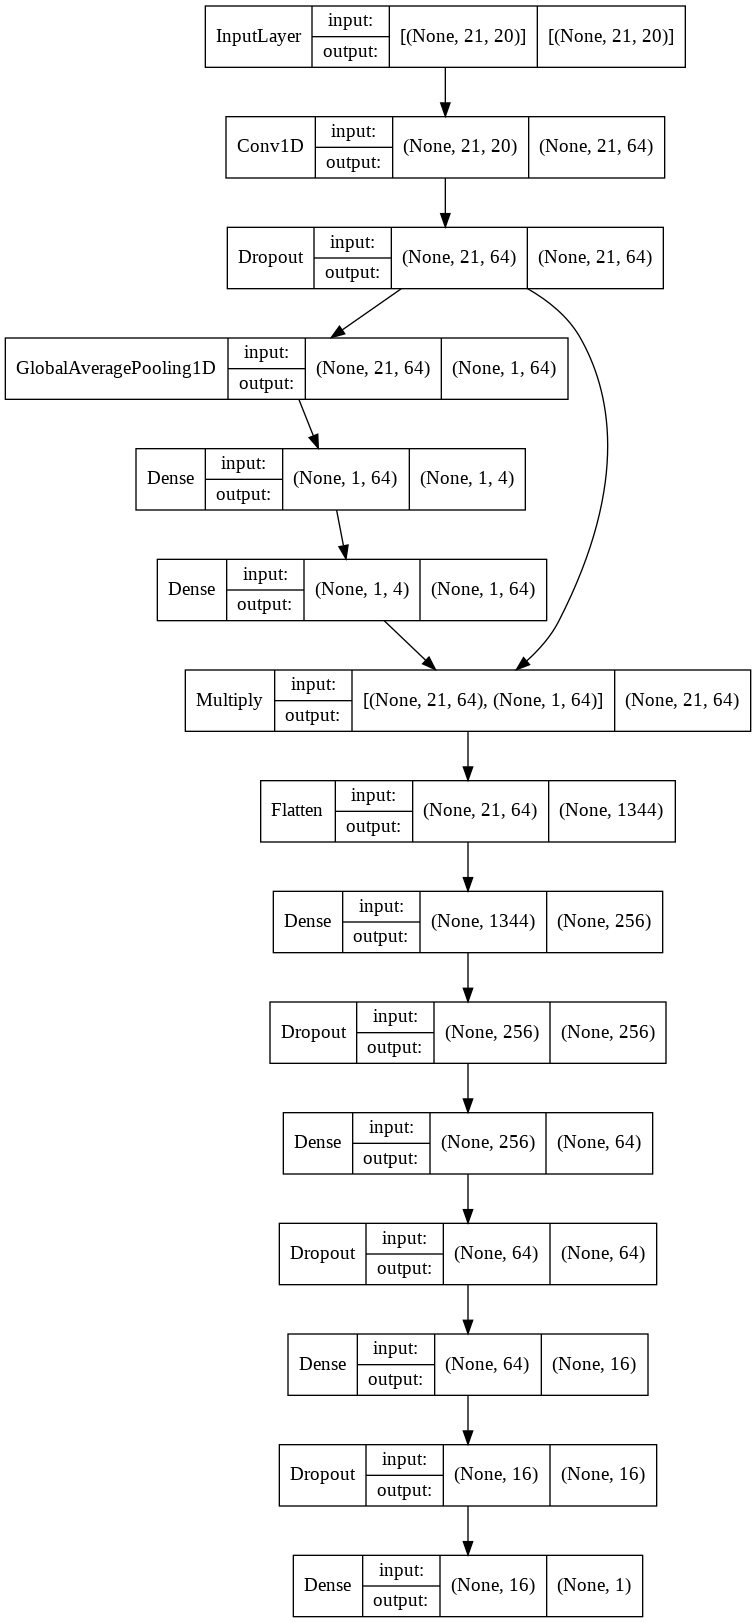

In [ ]:
model = get_evolutionary_model()
model.summary()
plot_model(model, to_file='model-pssm.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [ ]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# save the best model
mc = ModelCheckpoint('best_model_pssm.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# Compile Model:
#model = Ne()
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Run Model:
history = model.fit(x=trainX1, y= y_train, validation_data=(valX1, y_val), batch_size=32, epochs=200, verbose=1, callbacks=[es,mc])

Epoch 1/200
703/713 [============================>.] - ETA: 0s - loss: 0.6590 - accuracy: 0.6997
Epoch 1: val_accuracy improved from -inf to 0.70391, saving model to best_model_pssm.h5
713/713 [==============================] - 5s 5ms/step - loss: 0.6584 - accuracy: 0.7000 - val_loss: 0.6172 - val_accuracy: 0.7039
Epoch 2/200
706/713 [============================>.] - ETA: 0s - loss: 0.5880 - accuracy: 0.7349
Epoch 2: val_accuracy improved from 0.70391 to 0.71457, saving model to best_model_pssm.h5
713/713 [==============================] - 4s 5ms/step - loss: 0.5879 - accuracy: 0.7350 - val_loss: 0.5967 - val_accuracy: 0.7146
Epoch 3/200
704/713 [============================>.] - ETA: 0s - loss: 0.5386 - accuracy: 0.7680
Epoch 3: val_accuracy improved from 0.71457 to 0.79155, saving model to best_model_pssm.h5
713/713 [==============================] - 4s 5ms/step - loss: 0.5379 - accuracy: 0.7686 - val_loss: 0.4830 - val_accuracy: 0.7916
Epoch 4/200
702/713 [=========================

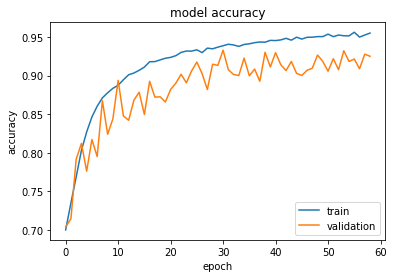

In [ ]:
from matplotlib import pyplot as plt
#plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='lower right')
plt.savefig('accuracy_curve_pssm_balanced_smote.png')
plt.show()

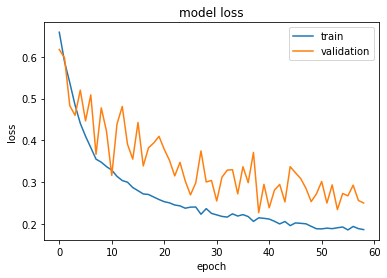

In [ ]:
#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.savefig('loss_curve_pssm_balanced_smote.png')
plt.show()

In [ ]:
saved_model = load_model('best_model_pssm.h5')
probabilities = saved_model.predict(valX1)
predicted_classes = probabilities >= 0.5
predicted_classes = predicted_classes.astype(int)
acc, sensitivity, specificity, precision, MCC = calculate_performance(len(y_val),predicted_classes , y_val)

print('Result Summary:')
print('------------------------------')
print('accuracy: ',acc, end =", ")
print('sensitivity: ',sensitivity, end =", ")
print('specificity: ',specificity, end =" ,")
print('precision: ',precision, end =" ,")
print('MCC : ',MCC)

Result Summary:
------------------------------
accuracy:  0.9328859060402684, sensitivity:  0.9967767929089444, specificity:  0.871517027863777 ,precision:  0.8816821097647898 ,MCC :  0.8732041693380822


In [ ]:
!pip install rotation-forest
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier,GradientBoostingClassifier
from rotation_forest import RotationForestClassifier
#ml_model = RandomForestClassifier(n_estimators=100, bootstrap=False, random_state=47, verbose=1)
ml_model = RotationForestClassifier(n_estimators=100, random_state=47, verbose=4, n_jobs=-2)
ml_model.fit(x_train[:, 420: ],y_train )
y_predict = ml_model.predict(x_test[:,420:])

  Created wheel for rotation-forest: filename=rotation_forest-1.0-py3-none-any.whl size=7002 sha256=0cd469f237899cb321ef9c5875d9f851cd83ac839726786caf08e71e9f010a63
  Stored in directory: /root/.cache/pip/wheels/1a/d7/d5/e657bdbc7feafd9f8808611ad808bcffbcb50c71dd93b9e8e4
Successfully built rotation-forest


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   28.1s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:   56.5s remaining:    0.0s


building tree 3 of 100


[Parallel(n_jobs=-2)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 10

[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed: 47.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished


In [ ]:
y_predict

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
model.save("model_pssm_conv1_train_balanced.h5")

In [ ]:
from tensorflow.keras.layers import Layer, InputSpec
def squeeze_excite_block(self, x):
	# store the input
	shortcut = x
	# calculate the number of filters the input has
	filters = x.shape[-1]
	# the squeeze operation reduces the input dimensionality
	# here we do a global average pooling across the filters, which
	# reduces the input to a 1D vector
	x = GlobalAveragePooling1D(keepdims=True)(x)
	# reduce the number of filters (1 x 1 x C/r)
	x = Dense(filters // self.ratio, activation="relu",
		kernel_initializer="he_normal", use_bias=False)(x)
	
	# the excitation operation restores the input dimensionality
	x = Dense(filters, activation="sigmoid",
		kernel_initializer="he_normal", use_bias=False)(x)
	
	# multiply the attention weights with the original input
	x = Multiply()([shortcut, x])
	# return the output of the SE block
	return x

In [ ]:
from tensorflow.keras.layers import Layer, InputSpec
class Position_Embedding(Layer):

    def __init__(self, size=None, mode='concat', **kwargs):

        self.size = size

        self.mode = mode

        super(Position_Embedding, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.size,
            "arg2": self.mode,
        })
        return config

    def call(self, x):

        if (self.size == None) or (self.mode == 'concat'):
            self.size = int(x.shape[-1])

        position_j = 1. / K.pow(10000., 2 * K.arange(self.size / 2, dtype='float32') / self.size)

        position_j = K.expand_dims(position_j, 0)

        position_i = K.cumsum(K.ones_like(x[:, :, 0]), 1) - 1

        position_i = K.expand_dims(position_i, 2)

        position_ij = K.dot(position_i, position_j)

        position_ij = K.concatenate([K.cos(position_ij), K.sin(position_ij)], 2)

        if self.mode == 'sum':

            return position_ij + x

        elif self.mode == 'concat':

            return K.concatenate([position_ij, x], 2)

    def compute_output_shape(self, input_shape):

        if self.mode == 'sum':

            return input_shape

        elif self.mode == 'concat':

            return (input_shape[0], input_shape[1], input_shape[2] + self.size)


class Self_Attention(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Self_Attention, self).__init__(**kwargs)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.output_dim,
        })
        return config

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(3, input_shape[2], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)

        super(Self_Attention, self).build(input_shape)

    def call(self, x):
        WQ = K.dot(x, self.kernel[0])
        WK = K.dot(x, self.kernel[1])
        WV = K.dot(x, self.kernel[2])
        QK = K.batch_dot(WQ, K.permute_dimensions(WK, [0, 2, 1]))
        QK = QK / (self.output_dim ** 0.5)
        QK = K.softmax(QK)
        V = K.batch_dot(QK, WV)
        return V

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.output_dim)

In [ ]:
self_number = 128
weight_decay=0.0001
def get_combined_model():
    ### Head-1:
    input1 = Input(shape=trainX1[0].shape)

    x = Conv1D(filters=64, kernel_size=5, padding='same', kernel_regularizer=l2(l=0.01))(input1)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.50)(x)

    shortcut = x
	  # calculate the number of filters the input has
    filters = x.shape[-1]
	  # the squeeze operation reduces the input dimensionality
	  # here we do a global average pooling across the filters, which
	  # reduces the input to a 1D vector
    x = GlobalAveragePooling1D()(x)
	  # reduce the number of filters (1 x 1 x C/r)
    x = Dense(filters // 16, activation="relu", kernel_initializer="he_normal", use_bias=False)(x)
	
	  # the excitation operation restores the input dimensionality
    x = Dense(filters, activation="sigmoid",kernel_initializer="he_normal", use_bias=False)(x)
	
	  # multiply the attention weights with the original input
    x = Multiply()([shortcut, x])


 

    #x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    #x = BatchNormalization()(x)
    #x = Dropout(rate=0.50)(x)

    head1 = Flatten()(x)

    #output = Dense(units=128, activation='relu',)(head1)
    #output = BatchNormalization()(output)
    #output = Dropout(rate=0.5)(output)

    #output = Dense(units=64, activation='relu',)(head1)
    #output = BatchNormalization()(output)
    #output = Dropout(rate=0.5)(output)


    #output = Dense(units=32, activation='relu',)(output)
    #output = BatchNormalization()(output)
    #output = Dropout(rate=0.5)(output)
    
    #output = Dense(units=8, activation='relu',)(output)
    #output = BatchNormalization()(output)
    #output = Dropout(rate=0.25)(output)

    x = Model(inputs=[input1], outputs=[head1])


        ### Head-1:
    input2 = Input(shape=trainX2[0].shape)

    y = Conv1D(filters=64, kernel_size=5, padding='same', kernel_regularizer=l2(l=0.01))(input2)
    y = BatchNormalization()(y)
    y = Dropout(rate=0.5)(y)

    shortcut2 = y
	  # calculate the number of filters the input has
    filters2 = y.shape[-1]
	  # the squeeze operation reduces the input dimensionality
	  # here we do a global average pooling across the filters, which
	  # reduces the input to a 1D vector
    y = GlobalAveragePooling1D(keepdims=True)(y)
	  # reduce the number of filters (1 x 1 x C/r)
    y = Dense(filters2 // 16, activation="relu", kernel_initializer="he_normal", use_bias=False)(y)
	
	  # the excitation operation restores the input dimensionality
    y = Dense(filters2, activation="sigmoid",kernel_initializer="he_normal", use_bias=False)(y)
	
	  # multiply the attention weights with the original input
    y = Multiply()([shortcut2, y])


    #y = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(y)
    #y = BatchNormalization()(y)
    #y = Dropout(rate=0.50)(y)

    head2 = Flatten()(y)
    #output2 = Dense(units=128, activation='relu',)(head2)
    #output2 = BatchNormalization()(output2)
    #output2 = Dropout(rate=0.5)(output2)

    #output2 = Dense(units=64, activation='relu',)(head2)
    #output2 = BatchNormalization()(output2)
    #output2 = Dropout(rate=0.5)(output2)


    #output2 = Dense(units=32, activation='relu',)(output2)
    #output2 = BatchNormalization()(output2)
    #output2 = Dropout(rate=0.5)(output2)
    
    #output2 = Dense(units=8, activation='relu',)(output2)
    #output2 = BatchNormalization()(output2)
    #output2 = Dropout(rate=0.5)(output2)


    y = Model(inputs=[input2], outputs=[head2])

    combined = concatenate([x.output, y.output])

    #z= Dense(units=2048, activation='relu')(combined)
    #output2 = BatchNormalization()(output2)
    #z = Dropout(rate=0.5)(z)

    z= Dense(units=1024, activation='relu')(combined)
    #output2 = BatchNormalization()(output2)
    z = Dropout(rate=0.5)(z)


    z= Dense(units=512, activation='relu')(z)
    #output2 = BatchNormalization()(output2)
    z = Dropout(rate=0.5)(z)

    #z= Dense(units=256, activation='relu')(z)
    #output2 = BatchNormalization()(output2)
    #z = Dropout(rate=0.5)(z)

    
    z= Dense(units=128, activation='relu')(z)
    #output2 = BatchNormalization()(output2)
    z = Dropout(rate=0.5)(z)

    #z = Dense(units=64, activation='relu')(z)
    #output2 = BatchNormalization()(output2)
    #z = Dropout(rate=0.5)(z)


    #z = Dense(units=32, activation='relu')(z)
    #output2 = BatchNormalization()(output2)
    #z = Dropout(rate=0.5)(z)
    
    z = Dense(units=16, activation='relu')(z)
    #output2 = BatchNormalization()(output2)
    #z = Dropout(rate=0.5)(z)
    #z = Dense(8, activation='relu')(z)
    #z = BatchNormalization()(z)
    #z = Dropout(rate=0.5)(z)
    z = Dense(1, activation='sigmoid')(z)
    
    # our model will accept the inputs of the two branches and
    # then output a single value
    return Model(inputs=[x.input, y.input], outputs=z)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21, 20)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 21, 8)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 21, 64)       6464        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 21, 64)       2624        ['input_2[0][0]']                
                                                                                            

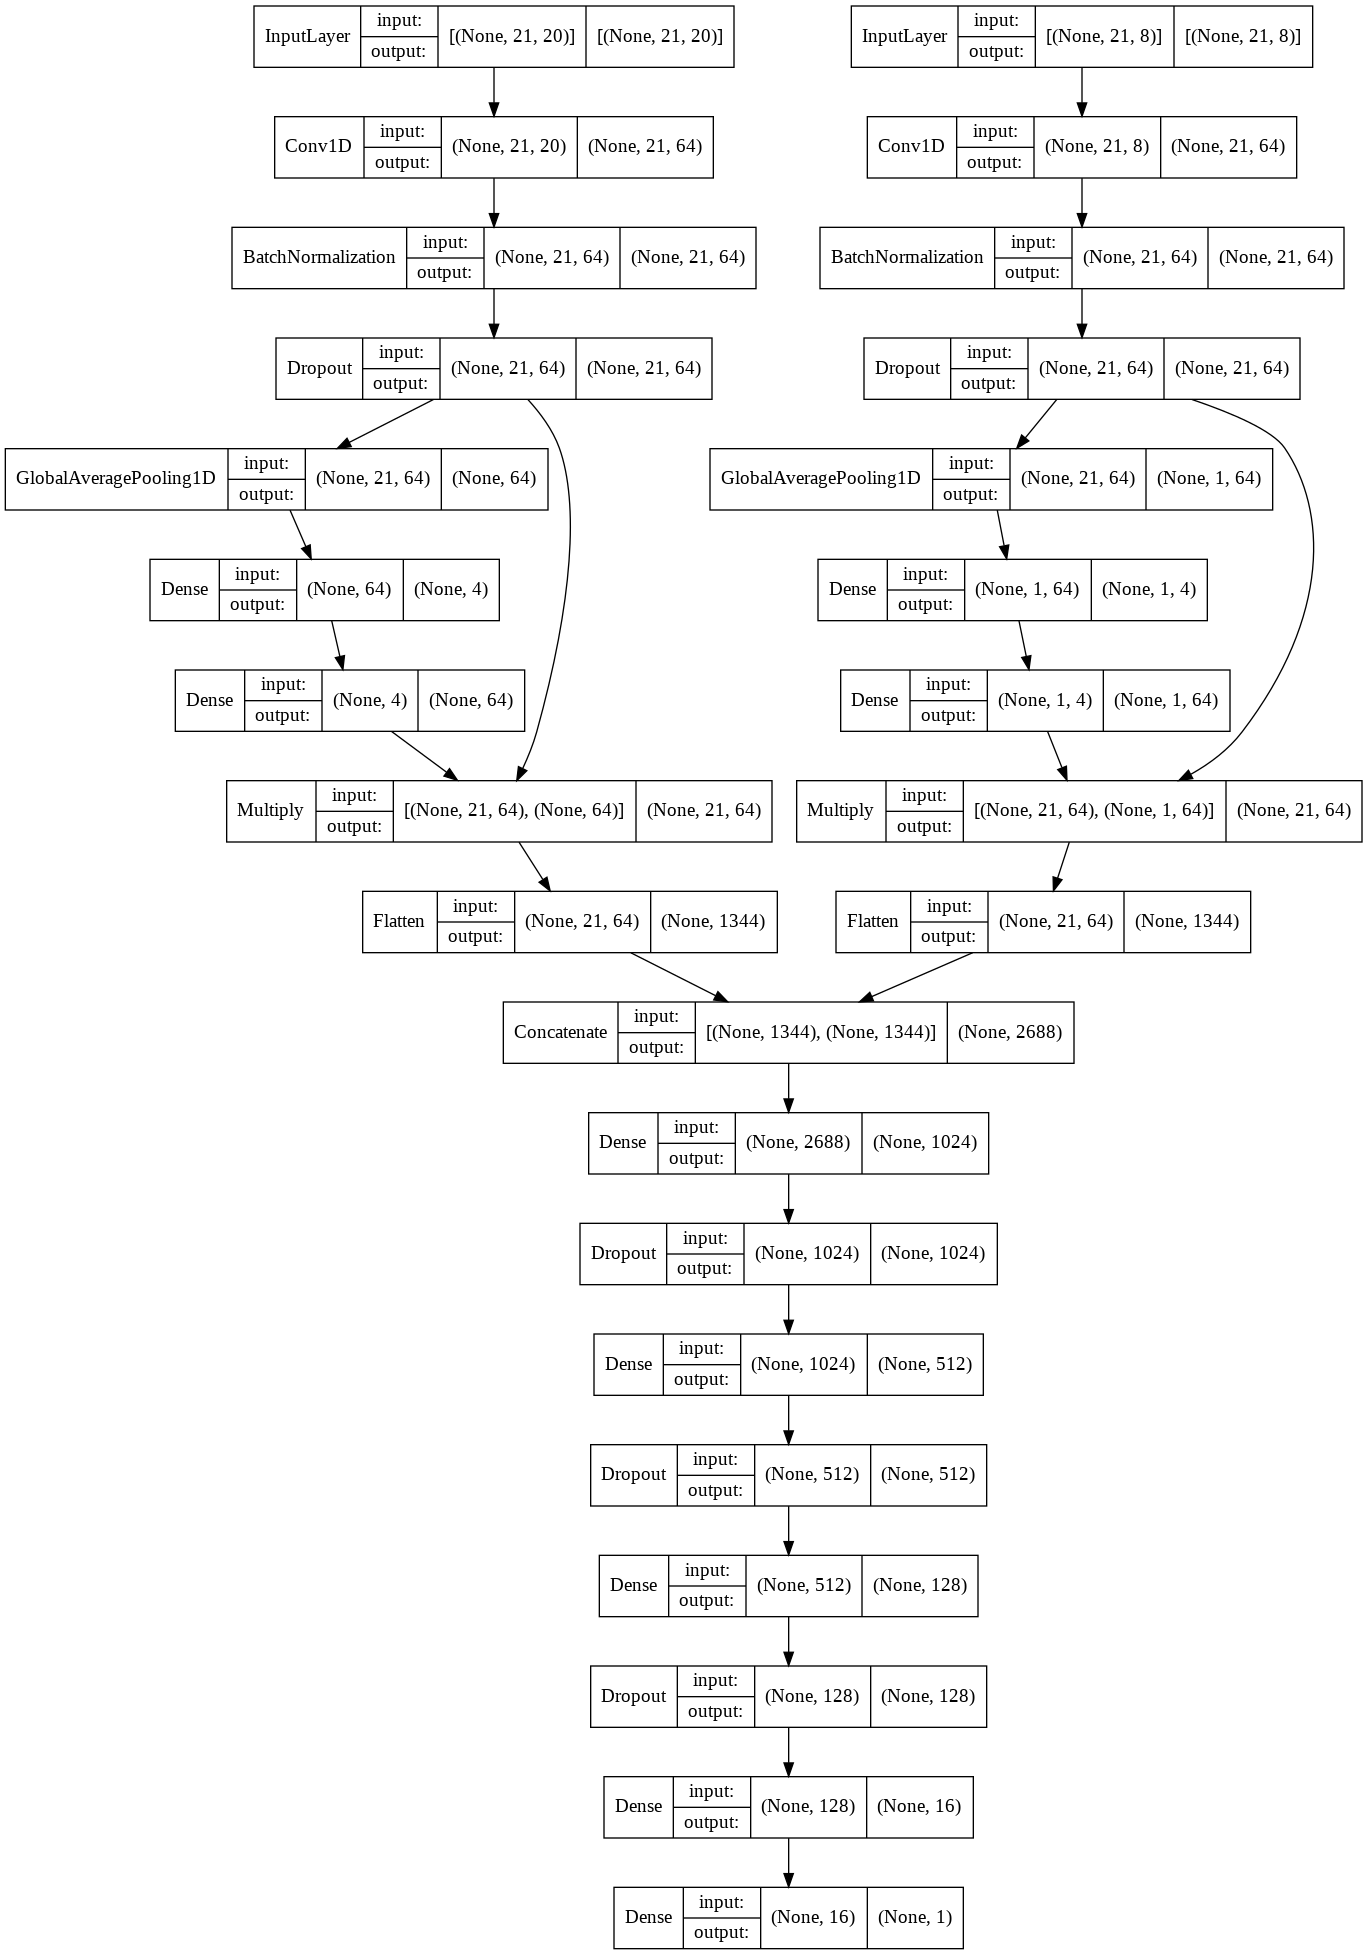

In [ ]:
import tensorflow.keras.backend as K
model = get_combined_model()
model.summary()
plot_model(model, to_file='model-combined.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [ ]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# save the best model
mc = ModelCheckpoint('best_model_combined.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# Compile Model:
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy',metrics=['accuracy'])

# Run Model:
#history = model.fit(x=trainX1, y= y_train, validation_data=(testX1, y_test), batch_size=16, epochs=100, verbose=1, callbacks=[])
history=model.fit(x=[trainX1, trainX2], y=y_train, validation_data=([valX1, valtX2], y_val), epochs=200, batch_size=32, callbacks=[es,mc], verbose = 1)

Epoch 1/200
713/713 [==============================] - ETA: 0s - loss: 0.9199 - accuracy: 0.6493
Epoch 1: val_accuracy improved from -inf to 0.71496, saving model to best_model_combined.h5
713/713 [==============================] - 6s 7ms/step - loss: 0.9199 - accuracy: 0.6493 - val_loss: 0.7276 - val_accuracy: 0.7150
Epoch 2/200
712/713 [============================>.] - ETA: 0s - loss: 0.6524 - accuracy: 0.7306
Epoch 2: val_accuracy improved from 0.71496 to 0.77773, saving model to best_model_combined.h5
713/713 [==============================] - 5s 7ms/step - loss: 0.6524 - accuracy: 0.7306 - val_loss: 0.5791 - val_accuracy: 0.7777
Epoch 3/200
713/713 [==============================] - ETA: 0s - loss: 0.5535 - accuracy: 0.7702
Epoch 3: val_accuracy improved from 0.77773 to 0.78326, saving model to best_model_combined.h5
713/713 [==============================] - 5s 7ms/step - loss: 0.5535 - accuracy: 0.7702 - val_loss: 0.5292 - val_accuracy: 0.7833
Epoch 4/200
709/713 [=============

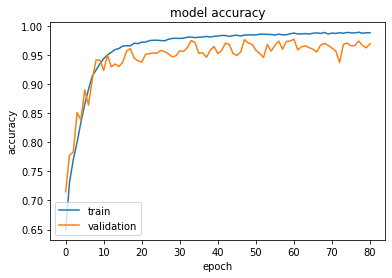

In [ ]:
from matplotlib import pyplot as plt
#plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='lower left')
plt.savefig('accuracy_curve_combined.png')
plt.show()

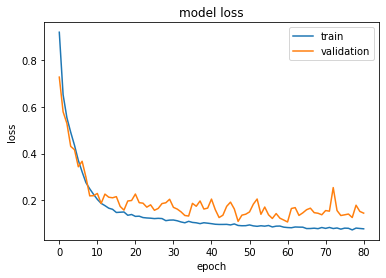

In [ ]:
#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.savefig('loss_curve_combined.png')
plt.show()

In [ ]:
probabilities = model.predict([testX1,testX2])
predicted_classes = probabilities >= 0.5
predicted_classes = predicted_classes.astype(int)

In [ ]:
res = model.evaluate([testX1,testX2], y_test)

110/110 [==============================] - 0s 4ms/step - loss: 0.7012 - accuracy: 0.8696


In [ ]:
res

[0.7012228965759277, 0.8695651888847351]

In [ ]:
acc,  sensitivity, specificity, precision, MCC = calculate_performance(len(y_test), predicted_classes, y_test)
print('Result Summary:')
print('------------------------------')
print('accuracy',acc, end =", ")
print('MCC',MCC, end =", ")
print('sensitivity',sensitivity, end =",")
print('precision',precision, end =",")
print('specificity',specificity)

Result Summary:
------------------------------
accuracy 0.8695652173913043, MCC 0.09109258002476257, sensitivity 0.1276595744680851,precision 0.1990521327014218,specificity 0.9466371960846227


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/best_model_combined.h5')
probabilities = model.predict([valX1,valtX2])
predicted_classes = probabilities >= 0.5
predicted_classes = predicted_classes.astype(int)

In [ ]:
acc,  sensitivity, specificity, precision, MCC = calculate_performance(len(y_val), predicted_classes, y_val)
print('Result Summary:')
print('------------------------------')
print('accuracy',acc, end =", ")
print('MCC',MCC, end =", ")
print('sensitivity',sensitivity, end =",")
print('precision',precision, end =",")
print('specificity',specificity)

Result Summary:
------------------------------
accuracy 0.97749703908409, MCC 0.9559843143299959, sensitivity 1.0,precision 0.9560862865947611,specificity 0.9558823529411765


In [ ]:
for idx, layer in enumerate(model.layers):
  print('{}->{}'.format(idx,layer))

0-><keras.engine.input_layer.InputLayer object at 0x7f6ea613ae10>
1-><keras.engine.input_layer.InputLayer object at 0x7f6e9015dd10>
2-><keras.layers.convolutional.Conv1D object at 0x7f6e9015dad0>
3-><keras.layers.convolutional.Conv1D object at 0x7f6f102bf990>
4-><keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f6e9015df50>
5-><keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f6e90122c10>
6-><keras.layers.core.dropout.Dropout object at 0x7f6e90162150>
7-><keras.layers.core.dropout.Dropout object at 0x7f6f102cafd0>
8-><keras.layers.pooling.GlobalAveragePooling1D object at 0x7f6ea61c91d0>
9-><keras.layers.pooling.GlobalAveragePooling1D object at 0x7f6ea60d9550>
10-><keras.layers.core.dense.Dense object at 0x7f6e90171ed0>
11-><keras.layers.core.dense.Dense object at 0x7f6e900e8650>
12-><keras.layers.core.dense.Dense object at 0x7f6e900e89d0>
13-><keras.layers.core.dense.Dense object at 0x7f6e900e8d90>
14-><keras.layers.merge.Mult

In [ ]:
# Outputs of the 8 layers, which include conv2D and max pooling layers
layer_outputs = model.layers[21]
activation_model = Model(inputs = model.input, outputs = layer_outputs.output)
activations = activation_model.predict([valX1, valtX2])

In [ ]:
activations[0].shape

(512,)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


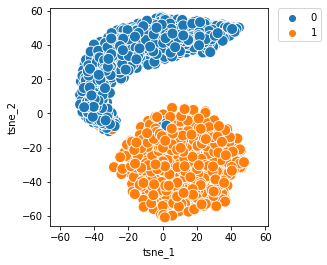

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(activations)
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y_val})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


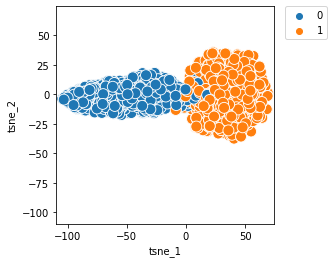

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(activations)
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y_val})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [ ]:
self_number = 128
weight_decay=0.0001
def get_combined_model_without_SE():
    ### Head-1:
    input1 = Input(shape=trainX1[0].shape)

    x = Conv1D(filters=64, kernel_size=5, padding='same', kernel_regularizer=l2(l=0.01))(input1)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.50)(x)

    #x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    #x = BatchNormalization()(x)
    #x = Dropout(rate=0.50)(x)

    head1 = Flatten()(x)

    #output = Dense(units=128, activation='relu',)(head1)
    #output = BatchNormalization()(output)
    #output = Dropout(rate=0.5)(output)

    #output = Dense(units=64, activation='relu',)(head1)
    #output = BatchNormalization()(output)
    #output = Dropout(rate=0.5)(output)


    #output = Dense(units=32, activation='relu',)(output)
    #output = BatchNormalization()(output)
    #output = Dropout(rate=0.5)(output)
    
    #output = Dense(units=8, activation='relu',)(output)
    #output = BatchNormalization()(output)
    #output = Dropout(rate=0.25)(output)

    x = Model(inputs=[input1], outputs=[head1])
        ### Head-1:
    input2 = Input(shape=trainX2[0].shape)

    y = Conv1D(filters=64, kernel_size=5, padding='same', kernel_regularizer=l2(l=0.01))(input2)
    y = BatchNormalization()(y)
    y = Dropout(rate=0.5)(y)




    #y = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(y)
    #y = BatchNormalization()(y)
    #y = Dropout(rate=0.50)(y)

    head2 = Flatten()(y)
    #output2 = Dense(units=128, activation='relu',)(head2)
    #output2 = BatchNormalization()(output2)
    #output2 = Dropout(rate=0.5)(output2)

    #output2 = Dense(units=64, activation='relu',)(head2)
    #output2 = BatchNormalization()(output2)
    #output2 = Dropout(rate=0.5)(output2)


    #output2 = Dense(units=32, activation='relu',)(output2)
    #output2 = BatchNormalization()(output2)
    #output2 = Dropout(rate=0.5)(output2)
    
    #output2 = Dense(units=8, activation='relu',)(output2)
    #output2 = BatchNormalization()(output2)
    #output2 = Dropout(rate=0.5)(output2)


    y = Model(inputs=[input2], outputs=[head2])

    combined = concatenate([x.output, y.output])

    #z= Dense(units=2048, activation='relu')(combined)
    #output2 = BatchNormalization()(output2)
    #z = Dropout(rate=0.5)(z)

    z= Dense(units=1024, activation='relu')(combined)
    #output2 = BatchNormalization()(output2)
    z = Dropout(rate=0.5)(z)


    z= Dense(units=512, activation='relu')(z)
    #output2 = BatchNormalization()(output2)
    z = Dropout(rate=0.5)(z)

    #z= Dense(units=256, activation='relu')(z)
    #output2 = BatchNormalization()(output2)
    #z = Dropout(rate=0.5)(z)

    
    z= Dense(units=128, activation='relu')(z)
    #output2 = BatchNormalization()(output2)
    z = Dropout(rate=0.5)(z)

    #z = Dense(units=64, activation='relu')(z)
    #output2 = BatchNormalization()(output2)
    #z = Dropout(rate=0.5)(z)


    #z = Dense(units=32, activation='relu')(z)
    #output2 = BatchNormalization()(output2)
    #z = Dropout(rate=0.5)(z)
    
    z = Dense(units=16, activation='relu')(z)
    #output2 = BatchNormalization()(output2)
    #z = Dropout(rate=0.5)(z)
    #z = Dense(8, activation='relu')(z)
    #z = BatchNormalization()(z)
    #z = Dropout(rate=0.5)(z)
    z = Dense(1, activation='sigmoid')(z)
    
    # our model will accept the inputs of the two branches and
    # then output a single value
    return Model(inputs=[x.input, y.input], outputs=z)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 21, 20)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 21, 8)]      0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 21, 64)       6464        ['input_3[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 21, 64)       2624        ['input_4[0][0]']                
                                                                                            

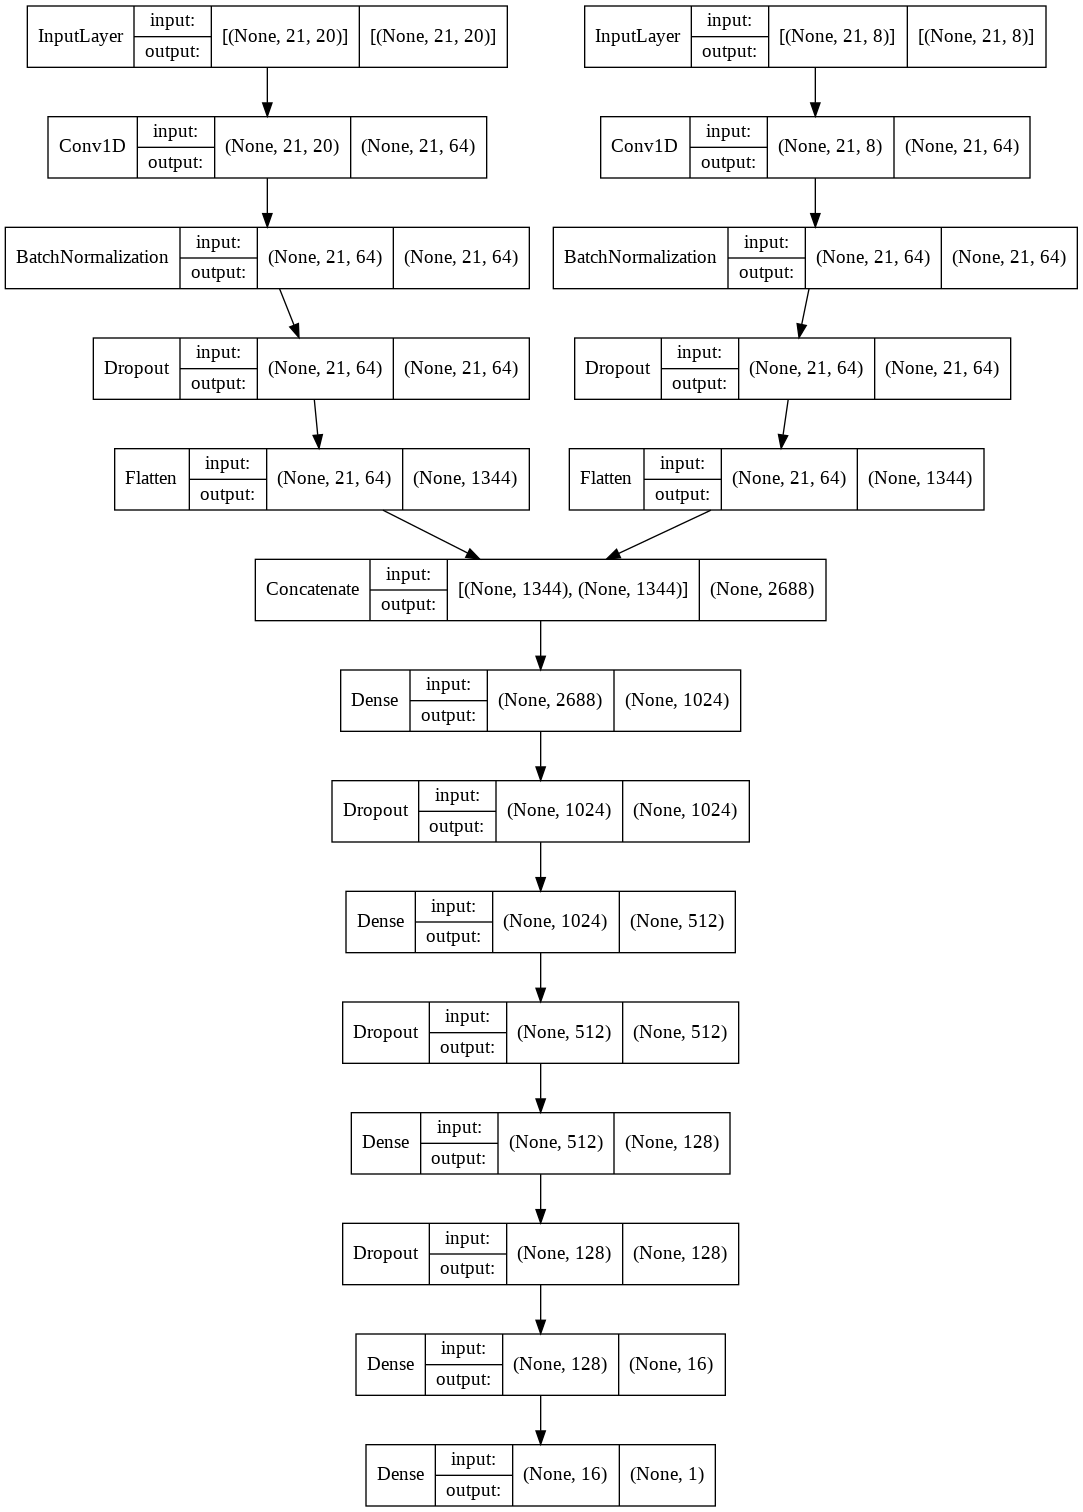

In [ ]:
import tensorflow.keras.backend as K
model = get_combined_model_without_SE()
model.summary()
plot_model(model, to_file='model-combined_without_SE.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [ ]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# save the best model
mc = ModelCheckpoint('best_model_combined_without_SE.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Compile Model:
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy',metrics=['accuracy'])

# Run Model:
#history = model.fit(x=trainX1, y= y_train, validation_data=(testX1, y_test), batch_size=16, epochs=100, verbose=1, callbacks=[])
history=model.fit(x=[trainX1, trainX2], y=y_train, validation_data=([valX1, valtX2], y_val), epochs=100, batch_size=32, callbacks=[es,mc], verbose = 1)

Epoch 1/100
713/713 [==============================] - ETA: 0s - loss: 1.0051 - accuracy: 0.6369
Epoch 1: val_accuracy improved from -inf to 0.71496, saving model to best_model_combined_without_SE.h5
713/713 [==============================] - 6s 7ms/step - loss: 1.0051 - accuracy: 0.6369 - val_loss: 0.7951 - val_accuracy: 0.7150
Epoch 2/100
704/713 [============================>.] - ETA: 0s - loss: 0.7032 - accuracy: 0.7181
Epoch 2: val_accuracy improved from 0.71496 to 0.75997, saving model to best_model_combined_without_SE.h5
713/713 [==============================] - 4s 6ms/step - loss: 0.7026 - accuracy: 0.7179 - val_loss: 0.6218 - val_accuracy: 0.7600
Epoch 3/100
711/713 [============================>.] - ETA: 0s - loss: 0.5850 - accuracy: 0.7543
Epoch 3: val_accuracy improved from 0.75997 to 0.77813, saving model to best_model_combined_without_SE.h5
713/713 [==============================] - 4s 6ms/step - loss: 0.5851 - accuracy: 0.7543 - val_loss: 0.5335 - val_accuracy: 0.7781
E

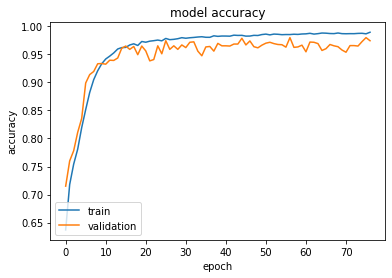

In [ ]:
from matplotlib import pyplot as plt
#plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='lower left')
plt.savefig('accuracy_curve_combined_without_SE.png')
plt.show()

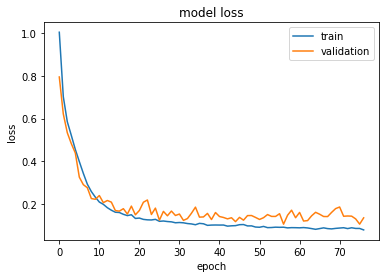

In [ ]:
#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.savefig('loss_curve_combined_without_SE.png')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/best_model_combined_without_SE.h5')
probabilities = model.predict([valX1,valtX2])
predicted_classes = probabilities >= 0.5
predicted_classes = predicted_classes.astype(int)
res = model.evaluate([testX1,testX2], y_test)

110/110 [==============================] - 1s 3ms/step - loss: 0.7913 - accuracy: 0.8790


In [ ]:
acc,  sensitivity, specificity, precision, MCC = calculate_performance(len(y_val), predicted_classes, y_val)
print('Result Summary:')
print('------------------------------')
print('accuracy',acc, end =", ")
print('MCC',MCC, end =", ")
print('sensitivity',sensitivity, end =",")
print('precision',precision, end =",")
print('specificity',specificity)

Result Summary:
------------------------------
accuracy 0.9798657718120806, MCC 0.960350036175415, sensitivity 0.9975825946817083,precision 0.9626749611197511,specificity 0.9628482972136223


In [ ]:
for idx, layer in enumerate(model.layers):
  print('{}->{}'.format(idx,layer))

0-><keras.engine.input_layer.InputLayer object at 0x7f6e00673d50>
1-><keras.engine.input_layer.InputLayer object at 0x7f6e00675250>
2-><keras.layers.convolutional.Conv1D object at 0x7f6e00675790>
3-><keras.layers.convolutional.Conv1D object at 0x7f6e00675c10>
4-><keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f6e00673f50>
5-><keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f6e006b1c10>
6-><keras.layers.core.dropout.Dropout object at 0x7f6e00673d10>
7-><keras.layers.core.dropout.Dropout object at 0x7f6e00730210>
8-><keras.layers.core.flatten.Flatten object at 0x7f6e82399bd0>
9-><keras.layers.core.flatten.Flatten object at 0x7f6e006e8450>
10-><keras.layers.merge.Concatenate object at 0x7f6e006dbfd0>
11-><keras.layers.core.dense.Dense object at 0x7f6e00701d90>
12-><keras.layers.core.dropout.Dropout object at 0x7f6e8206b590>
13-><keras.layers.core.dense.Dense object at 0x7f6e82401990>
14-><keras.layers.core.dropout.Dropout obje

In [ ]:
# Outputs of the 8 layers, which include conv2D and max pooling layers
layer_outputs = model.layers[13]
activation_model = Model(inputs = model.input, outputs = layer_outputs.output)
activations = activation_model.predict([valX1, valtX2])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


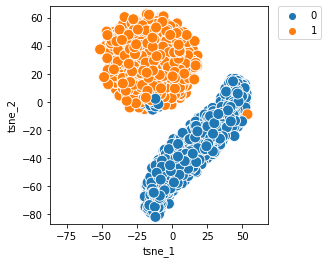

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(activations)
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y_val})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)